In [3]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

In [4]:
# Load TON-IoT dataset
df = pd.read_csv("data/train_test_network.csv")

# Shuffle dataset 
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Use the "type" column as label 
y = df["type"]
X = df.drop(columns=["label", "type"])

# Split 70% train, 15% validation, 15% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.1765, 
    random_state=42,
    stratify=y_train_val
)

# Save splits into CSV files
pd.concat([X_train, y_train], axis=1).to_csv("data/ton_train.csv", index=False)
pd.concat([X_val, y_val], axis=1).to_csv("data/ton_val.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("data/ton_test.csv", index=False)

print("Saved ton_train.csv, ton_val.csv, ton_test.csv")


Saved ton_train.csv, ton_val.csv, ton_test.csv


In [5]:
# Load split CSVs
train_df = pd.read_csv("data/ton_train.csv")
val_df = pd.read_csv("data/ton_val.csv")
test_df = pd.read_csv("data/ton_test.csv")

# Separate features + labels
X_train = train_df.drop(columns=["type"])
y_train = train_df["type"]

X_val = val_df.drop(columns=["type"])
y_val = val_df["type"]

X_test = test_df.drop(columns=["type"])
y_test = test_df["type"]

categorical_cols = [col for col in X_train.columns if X_train[col].dtype == object]

# Use OrdinalEncoder with safe handling of unseen categories
enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# Fit on ALL categorical data (train + val + test)
combined = pd.concat([
    X_train[categorical_cols].astype(str),
    X_val[categorical_cols].astype(str),
    X_test[categorical_cols].astype(str)
])

enc.fit(combined)

X_train[categorical_cols] = enc.transform(X_train[categorical_cols].astype(str))
X_val[categorical_cols] = enc.transform(X_val[categorical_cols].astype(str))
X_test[categorical_cols] = enc.transform(X_test[categorical_cols].astype(str))


# Verify no object columns remain
print("Remaining object columns:", X_train.dtypes[X_train.dtypes == "object"])


# Encode target labels
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
y_val   = label_enc.transform(y_val)
y_test  = label_enc.transform(y_test)

# Train model
model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train)),
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

Remaining object columns: Series([], dtype: object)
[0]	validation_0-mlogloss:1.83287
[1]	validation_0-mlogloss:1.55455
[2]	validation_0-mlogloss:1.34620
[3]	validation_0-mlogloss:1.18187
[4]	validation_0-mlogloss:1.04382
[5]	validation_0-mlogloss:0.92711
[6]	validation_0-mlogloss:0.82795
[7]	validation_0-mlogloss:0.74190
[8]	validation_0-mlogloss:0.66681
[9]	validation_0-mlogloss:0.60133
[10]	validation_0-mlogloss:0.54301
[11]	validation_0-mlogloss:0.49126
[12]	validation_0-mlogloss:0.44506
[13]	validation_0-mlogloss:0.40422
[14]	validation_0-mlogloss:0.36787
[15]	validation_0-mlogloss:0.33537
[16]	validation_0-mlogloss:0.30536


sh: line 1: nvidia-smi: command not found


[17]	validation_0-mlogloss:0.27826
[18]	validation_0-mlogloss:0.25442
[19]	validation_0-mlogloss:0.23256
[20]	validation_0-mlogloss:0.21261
[21]	validation_0-mlogloss:0.19480
[22]	validation_0-mlogloss:0.17873
[23]	validation_0-mlogloss:0.16428
[24]	validation_0-mlogloss:0.15093
[25]	validation_0-mlogloss:0.13888
[26]	validation_0-mlogloss:0.12784
[27]	validation_0-mlogloss:0.11778
[28]	validation_0-mlogloss:0.10863
[29]	validation_0-mlogloss:0.10041
[30]	validation_0-mlogloss:0.09295
[31]	validation_0-mlogloss:0.08622
[32]	validation_0-mlogloss:0.08016
[33]	validation_0-mlogloss:0.07448
[34]	validation_0-mlogloss:0.06944
[35]	validation_0-mlogloss:0.06466
[36]	validation_0-mlogloss:0.06058
[37]	validation_0-mlogloss:0.05665
[38]	validation_0-mlogloss:0.05312
[39]	validation_0-mlogloss:0.04991
[40]	validation_0-mlogloss:0.04693
[41]	validation_0-mlogloss:0.04432
[42]	validation_0-mlogloss:0.04179
[43]	validation_0-mlogloss:0.03948
[44]	validation_0-mlogloss:0.03748
[45]	validation_0-ml

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [6]:
# Validation results
val_pred = model.predict(X_val)
print("\nValidation Results")
print(classification_report(y_val, val_pred, target_names=label_enc.classes_, digits=4))
print("Validation Accuracy:", accuracy_score(y_val, val_pred))


Validation Results
              precision    recall  f1-score   support

    backdoor     0.9997    1.0000    0.9998      3000
        ddos     0.9940    0.9907    0.9923      3000
         dos     0.9927    0.9930    0.9928      3001
   injection     0.9917    0.9927    0.9922      3001
        mitm     0.8834    0.9231    0.9028       156
      normal     0.9999    1.0000    0.9999      7501
    password     0.9953    0.9950    0.9952      3001
  ransomware     1.0000    1.0000    1.0000      3000
    scanning     0.9953    0.9943    0.9948      3001
         xss     0.9997    1.0000    0.9998      3001

    accuracy                         0.9964     31662
   macro avg     0.9852    0.9889    0.9870     31662
weighted avg     0.9964    0.9964    0.9964     31662

Validation Accuracy: 0.996367885793696


In [14]:
# Test results
test_pred = model.predict(X_test)
print("\nTest Results:")
print(classification_report(y_test, test_pred, target_names=label_enc.classes_, digits=4))
print("Test Accuracy:", accuracy_score(y_test, test_pred))


Test Results:
              precision    recall  f1-score   support

    backdoor     1.0000    1.0000    1.0000      3000
        ddos     0.9940    0.9937    0.9938      3000
         dos     0.9923    0.9900    0.9912      3000
   injection     0.9910    0.9893    0.9902      3000
        mitm     0.8750    0.9363    0.9046       157
      normal     0.9997    0.9999    0.9998      7500
    password     0.9950    0.9933    0.9942      3000
  ransomware     0.9997    1.0000    0.9998      3000
    scanning     0.9923    0.9937    0.9930      3000
         xss     0.9997    1.0000    0.9998      3000

    accuracy                         0.9959     31657
   macro avg     0.9839    0.9896    0.9866     31657
weighted avg     0.9959    0.9959    0.9959     31657

Test Accuracy: 0.9958618946836403


In [15]:
# Save model 
model.save_model("model/xgbmodel(TON_IoT).json")
print("Saved model to xgb_ton_model.json")

Saved model to xgb_ton_model.json


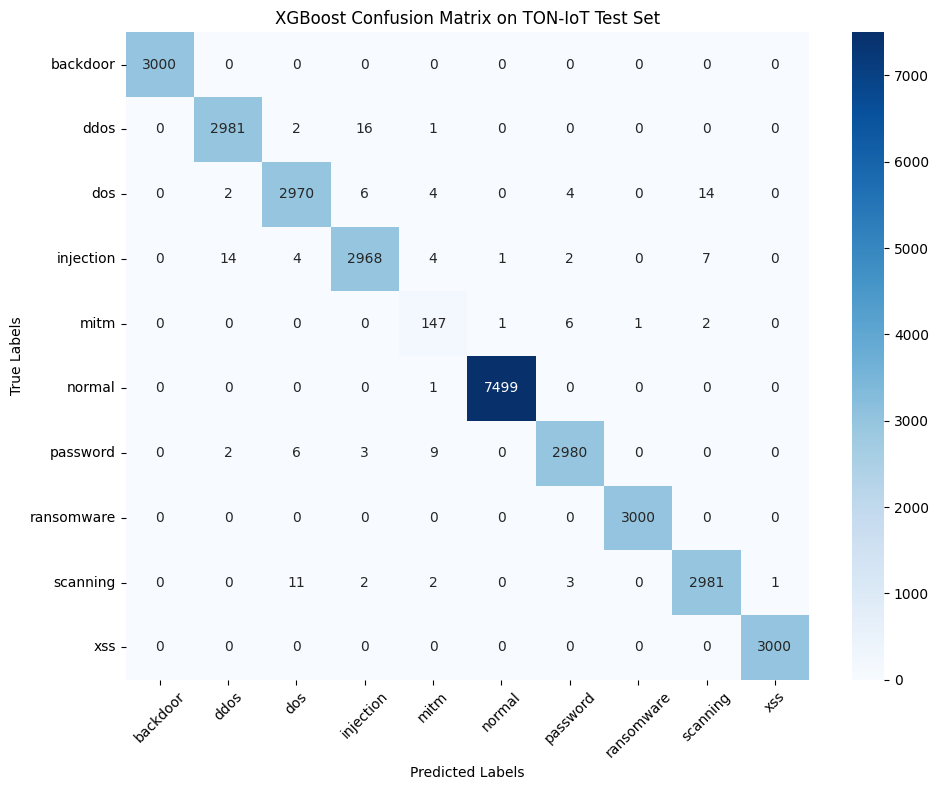

In [16]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_enc.classes_, yticklabels=label_enc.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("XGBoost Confusion Matrix on TON-IoT Test Set")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
